# OWA Anholt Array Efficiency: Benchmark Evaluation Script
*Javier Sanz Rodrigo, Fernando Borbón, Pedro Miguel Fernandes Correia, Pawel Gancarski (CENER)* 

*February 2019*

## Introduction
This is the model evaluation script for the [OWA-Anholt Array Efficiency benchmark](https://thewindvaneblog.com/the-owa-anholt-array-efficiency-benchmark-436fc538597d) as part of the [OWA Wake Modeling Challenge](https://www.carbontrust.com/media/677495/owa-wake-modelling-challenge_final-feb27.pdf).



## Simulations
The following models participate in the benchmark.

**Table 1. Participating models.**

| simID | Model | Type | Remarks |  
|:----:|:-----:|:----------:|:--------:|
| anh01 | XXX | time series  | - | 
| anh02 | XXX | time series  | - | 
| anh03 | XXX | time series  | - | 
| anh04 | XXX | time series  | - | 
| anh05 | XXX | time series  | - | 
| anh06 | XXX | time series  | - | 
| anh07 | XXX | bin averages | - | 

In [112]:
sim_id =    ['anh01','anh03','anh04','anh05','anh06','anh07']
sim_model = ['ENG'  ,'RANS' ,'LES'  ,'RANS' ,'XXX'  ,'XXX'  ]
sim_type =  ['ts'   ,'ts'   ,'ts'   ,'ts'   ,'ts'   ,'ba'   ]

## Load libraries

In [113]:
%matplotlib inline
from src.WindConditions import *
from src.BinAvrg import *  
from scipy import interpolate
from IPython.display import Markdown, display

## Wind farm input data 
The scada_flags dataframe indicates which timestamps have been filtered out in the quality-control process of the SCADA data. This allows to perform the evaluation on validation dataset which only contains situations where the wind farm is operating in normal conditions.

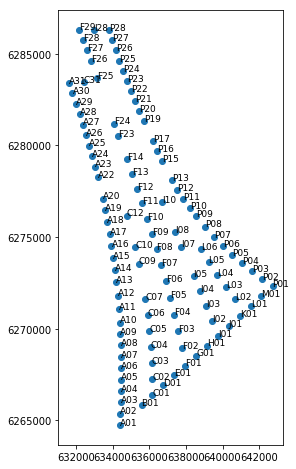

In [114]:
# setup
datefrom = time_stamp(2013,1,1,0,0,0)    # evaluation period
dateto = time_stamp(2015,6,30,23,0,0)    # evaluation period

siteID = 'Anholt'
Hhub = 81.6         # hub-height
Drot = 120          # rotor diameter
lat_ref = 56.6      # degrees N 
lon_ref = 11.2      # degrees E

# Load manufacturer's power curve 
pwr_curve_file = pd.read_csv('./inputs/Anholt_pwc.csv', sep = ';')
pwr_curve_file['power'] = pwr_curve_file['power']/1000 # scale to MW
pwr_curve = interpolate.interp1d(pwr_curve_file['U'].values.flatten(),pwr_curve_file['power'].values.flatten(), 
                                bounds_error = False, fill_value = 0)
# when converting power to speed use the rev_pwr_curve
###rev_pwr_curve = interpolate.interp1d(pwr_curve_file['power'].values.flatten(),pwr_curve_file['U'].values.flatten())

# Load wind farm layout data
turbines = pd.read_csv("inputs/Anholt_layout.csv")
plot_wf_layout(turbines['X coordinate'], turbines['Y coordinate'],labels = turbines['VDC ID'])

## Read data availability flags
This file is provided to the participants so they can compute their bin-averages using the same timestamps of the validation data. Notice that:

* $min\_data\_availability$ sets the minimum availability of original (non-reconstructed) observational data, i.e. for 90%, no more than 10% is reconstructed.

* $scada\_ts$ list the time stamps that will be retained in the analysis

In [115]:
scada_flags = pd.read_csv('./inputs/obs_flags.csv', index_col = 'time') 
min_data_availability = 90 # minimum data availability in %
scada_ts = flags_to_ts(scada_flags, min_data_availability) # generate a list of accepted time series

print("Hence, after applying the filter we get %d hourly samples, which is %.2f%% of the original data" % (scada_ts.shape[0],scada_ts.shape[0]*100/scada_flags.shape[0]))

Hence, after applying the filter we get 11495 hourly samples, which is 52.58% of the original data


## Wind conditions from mesoscale input data
In the absence of an *undisturbed* met mast, the wind farm centroid is used as reference site to define wind conditions and classify the wind climate in terms of wind direction sectors and stability classes. This site has also been used as the center of the innermost domain in the WRF set-up.

**Fig 1. Distributions at zref for all data (above) and retained for validation (below)**

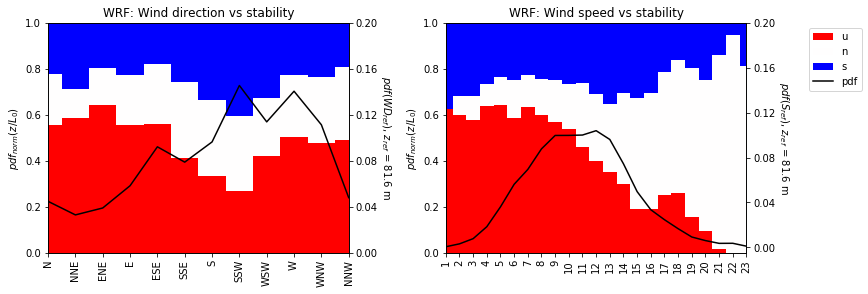

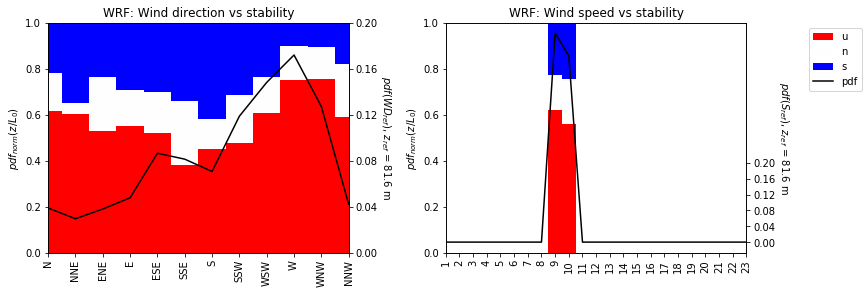

In [116]:
# Define bins to classify wind conditions 
Sbins = np.array([8,10])              # around the maximum of the trust coefficient 
WDbins = np.arange(-15.,360.+15.,30)  # wind direction bins (12 sectors)
WDbins_label = ['N','NNE','ENE','E','ESE','SSE',
                'S','SSW','WSW','W','WNW','NNW']
zLbins = [-0.2,-0.02, 0.02, 0.2]      # 3 stability bins
zLbins_label = ['u','n','s']

# interpolate to reference height
zref = Hhub         # [m]

# Load mesoscale data from the referent site (time-height profiles)
mast = WindConditions('./inputs/Anholt_Lav30km_ref.nc',lat_ref, lon_ref, siteID, datefrom, dateto)

#init the bin averaging class
bin_avrg = BinAvrg(siteID,datefrom, dateto, WDbins, WDbins_label, zLbins, zLbins_label,turbines['VDC ID'],sim_id)

#filter for wind speed bin
scada_ts = bin_avrg.filter_s(mast, zref, scada_ts, Sbins)

# Compute and plot distributions 
N_WDzL_all,_,_,_,_ = mast.plot_stability(WDbins,WDbins_label,zLbins,zLbins_label,zref)

# after filtering
mast.reduce_to_ts(scada_ts)
N_WDzL_speed,_,_,_,_ = mast.plot_stability(WDbins,WDbins_label,zLbins,zLbins_label,zref)

figcaption = ("**Fig 1. Distributions at zref for all data (above) and retained for validation (below)**")
display(Markdown(figcaption))

In [117]:
print("Hence, after filtering for the wind speed, stability and direction bins, there are %d hourly samples (%.2f%% of the original data) distributed according to the following validation bins:" % (N_WDzL_speed.sum().sum(), N_WDzL_speed.sum().sum()*100/scada_flags.shape[0]))
N_WDzL_speed

Hence, after filtering for the wind speed, stability and direction bins, there are 2140 hourly samples (9.79% of the original data) distributed according to the following validation bins:


,u,n,s
N,51.0,14.0,18.0
NNE,38.0,3.0,22.0
ENE,43.0,19.0,19.0
E,56.0,16.0,30.0
ESE,96.0,33.0,56.0
SSE,66.0,49.0,59.0
S,68.0,20.0,63.0
SSW,121.0,53.0,80.0
WSW,192.0,50.0,75.0
W,277.0,54.0,37.0


Now we load the mesoscale data interpolated at the turbine positions to generate reference power data that will be used in the definition of array efficiency.

In [118]:
# Load mesoscale data at turbine positions (time-series at hub-height)
f = netCDF4.Dataset('./inputs/Anholt_WindTurbines.nc', 'r')
meso_ts_windspeed = pd.DataFrame(
            (f.variables['U'][:].data**2 + f.variables['V'][:].data**2)**0.5, 
            index = f.variables['Times'][:].data)
meso_ts_windspeed = restrict_to_ts(meso_ts_windspeed, scada_ts)

meso_ts_power = meso_ts_windspeed.transform(pwr_curve) # convert to power

Create mapping of time stamps per wind direction and stability bins

In [119]:
# create mapping, 
ts_bin_map = bin_avrg.create_ts_to_bin_map(mast, zref, scada_ts)
# where ts_bin_map[0][0] provides indices to samples in the N-u bin  

# Compute bin-averaged (and std) quantities,
meso_P, meso_P_std = bin_avrg.compute_mean(meso_ts_power, ts_bin_map)
# where a 3D array is created, e.g. meso_p.loc['ANHA01'].loc['N'].loc['u'] provides the mean power at 
# turbine A01 for North sector in unstable conditions

## Load simulation data

In [120]:
# Loop through the submitted simulation data files and categorize them according to Table 1
n_sim = len(sim_id)
sim_ts = []
sim_P = bin_avrg.array_init(('sim', 'wt','wd','zL'))
sim_P_std = bin_avrg.array_init(('sim', 'wt','wd','zL'))

for isim in range(0,n_sim):
    file_name = './outputs/'+ sim_id[isim] +'.csv'
    ts = p = p_std = None
    if sim_type[isim] == 'ts': 
        ts = pd.read_csv(file_name, index_col = 'time')  # read .csv output files
        p, p_std = bin_avrg.compute_mean(ts, ts_bin_map)   # from time-series to bin-averaged quantities
        # clean up the time series data and apply the scada_ts filter
        ts = restrict_to_ts(ts, scada_ts)
    else:
        p = bin_avrg.read_ba_file(file_name)
    sim_ts.append(ts)
    sim_P[isim] = p
    sim_P_std[isim] = p_std
    
# where sim_P.loc['anh01'].loc['ANHA01'].loc['N'].loc['u'] provides the mean power for anh01 simulation at 
# turbine A01 for North sector in unstable conditions

## Load validation data
To increase the data availability, a machine learning algorithm has been applied to recover data from turbines that are not working in nominal conditions from others that do. Then, the "gap-filled" observational data is loaded and the scada_ts filter applied to syncronize with the simulation data for validation.

In [123]:
try:
    obs_ts = pd.read_csv('./observations/obs.csv', index_col = 'time') 
    obs_P, obs_P_std = bin_avrg.compute_mean(ts_obs, ts_bin_map)  
    # clean up the time series data and apply the scada_ts filter
    obs_ts = restrict_to_ts(obs_ts, scada_ts)
    val_data = True
except IOError:
    print ("No validation data available")
    val_data = False

If no validation data is available, do code to code comparison by selecting a reference simulation to compare against:

In [124]:
ref_sim = 0

if val_data:
    ref_P = obs_P
    ref_P_std = obs_P_std
else: 
    ref_P = sim_P[ref_sim]
    ref_P_std = sim_P_std[ref_sim]

## Compute quantities of interest and metrics
*Array efficiency* for a wind turbine is defined as:

$$ \eta_{i} = \frac{P_i}{P(S_i)} $$

and for the whole wind farm as: 

$$ \eta = \frac{\sum_{i}P_i}{\sum_{i}P(S_i)} $$

where $P_i$ is the power of turbine $i$, observed or simulated, and $P(S_i)$ is the theoretical power from the manufaturer's power curve computed at the background (mesoscale) wind speed $S_i$ at each turbine position.  

Performance is measured in terms of the BIAS:

$$ BIAS = \eta_{obs} - \eta_{sim} $$ 

for each bin and for the whole wind distribution.

In [126]:
#init the arrays
sim_eta = bin_avrg.array_init(('sim', 'wd','zL'))
bias = bin_avrg.array_init(('sim', 'wd','zL'))
dif_std = bin_avrg.array_init(('sim', 'wd','zL'))
bias_tot = bin_avrg.array_init(('sim',))
mae = bin_avrg.array_init(('sim',))
len_array = np.vectorize(len)
bin_sizes = len_array(ts_bin_map)
sum_bin_sizes = bin_sizes.sum()
meso_P_sum = np.sum(meso_P,axis=0) 

#compute variables of interest
ref_eta = np.sum(ref_P,axis=0) / meso_P_sum * 100 # axis=0 are turbines

ref_dif_std = np.mean(ref_P_std - meso_P_std,axis=0)
for isim in range(n_sim):
    sim_eta[isim] = np.sum(sim_P[isim],axis=0) / meso_P_sum * 100
    bias[isim] = ref_eta - sim_eta[isim]
    if sim_P_std[isim] is not None:
        dif_std[isim] = np.mean(sim_P_std[isim] - ref_P_std,axis=0)

    bias_tot[isim] = (bias[isim]*bin_sizes).sum()/sum_bin_sizes
    mae[isim] = (np.absolute(bias[isim])*bin_sizes).sum()/sum_bin_sizes

## Plot results

**Heat maps of bin-averaged array efficiency and bias**

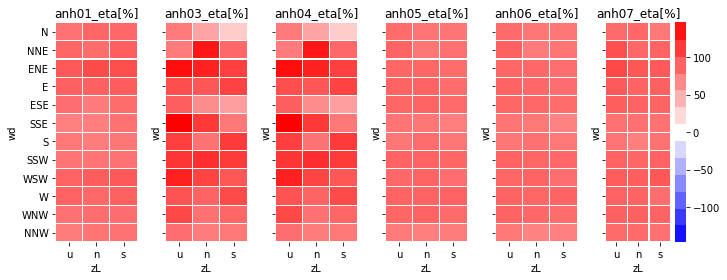

**Fig 2. Heat map of array efficiency**

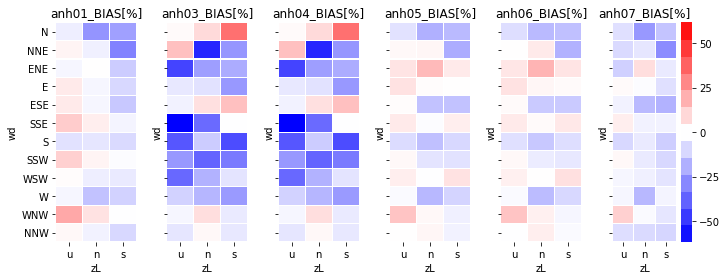

**Fig 3. Heat map of array efficiency BIAS**

In [130]:
#figcaption = "**Fig 2. Heat map of array efficiency**"
#title = "_eta[%]"
#bin_avrg.plot_heatmaps(sim_eta, sub_plt_size = (1.7,4),n_plot_cols = 6, 
#                       figcaption = figcaption, title=title)

figcaption = "**Fig 3. Heat map of array efficiency BIAS**"
title = "_BIAS[%]"
bin_avrg.plot_heatmaps(bias, sub_plt_size = (1.7,4),n_plot_cols = 6, 
                       figcaption = figcaption, title=title)

Integrate along wind direction to obtain the bias vs stability

In [129]:
(np.sum(bias,axis=1)/len(WDbins)).to_pandas()

zL,u,n,s
sim,,,
anh01,3.416875,-3.643907,-9.675797
anh03,-16.906566,-13.657846,-10.516308
anh04,-16.906566,-13.657846,-10.516308
anh05,1.911256,-3.827016,-5.282823
anh06,1.684862,-2.192669,-3.966228
anh07,-2.648351,-6.435087,-9.448006


**Efficiency and bias per wind turbine**

In [133]:
sim_eta_wt = bin_avrg.array_init(('sim', 'wt','wd','zL'))
bias_wt = bin_avrg.array_init(('sim', 'wt','wd','zL'))

ref_eta_wt = ref_P / meso_P * 100
ref_eta_wt_max = (ref_P + ref_P_std/2) / meso_P * 100

for isim in range(n_sim):
    sim_eta_wt[isim] = sim_P[isim] / meso_P * 100
    bias_wt[isim] = ref_eta_wt - sim_eta_wt[isim]

**Plot a transect, for chosen bin and wind turbines list**

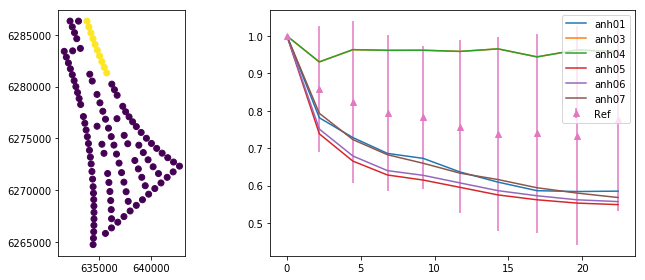

In [136]:
# Transect: Choose bin (WD,zL), define list of turbines and plot profiles of array efficiency along the transect of turbines. 
#           Normalized by dividing with eta of the first turbine in the list
#           Use error bars showind one std about the observed array efficiency (eta_obs_std)

#for list of turbines and wd, 2D plot Value per distance in rotor diameter. 
data =   sim_eta_wt.loc[:,:,'NNW','u'].to_pandas()
ref_data = ref_eta_wt.loc[:,'NNW','u'].to_pandas()
ref_data_max = ref_eta_wt_max.loc[:,'NNW','n'].to_pandas()

#from P28 to P19 
wt_list = ['ANHP'+str(28-i) for i in range(10)]

plot_transect(data,ref_data,ref_data_max,wt_list,turbines,Drot)

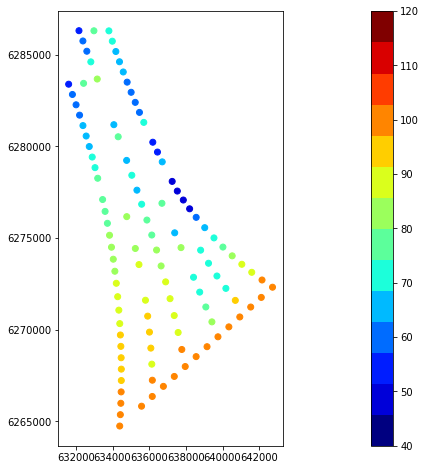

In [137]:
data = sim_eta_wt.loc['anh05',:,'SSE','u'].to_pandas()
plot_wf_layout(turbines['X coordinate'], turbines['Y coordinate'],data = data,vmin=40, vmax=120)

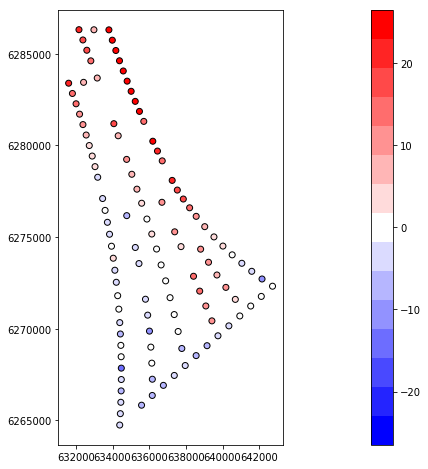

In [139]:
data = bias_wt.loc['anh05',:,'SSE','u'].to_pandas()
plot_wf_layout(turbines['X coordinate'], turbines['Y coordinate'],data = data)